In [1]:
import sklearn
import numpy as np
import os

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.style.use("seaborn-dark")

# 불필요한 경고를 무시
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# 1. Linear Regression
- analytic method (least square)
- iterative method (gradient descent)

In [2]:
?np.random.rand

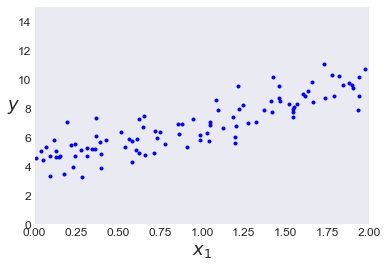

In [3]:
# sample data create
X = 2*np.random.rand(100, 1)                # 2*(0 ~ 1 random float)
y = 4 + 3*X + np.random.randn(100, 1)       # add gaussian noise

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.show()

### solution by Normal Equation

In [4]:
# true parameter : 4, 3
X_b = np.c_[np.ones((100, 1)), X]
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
print(theta_best)

[[4.21509616]
 [2.77011339]]


[[4.21509616]
 [9.75532293]]


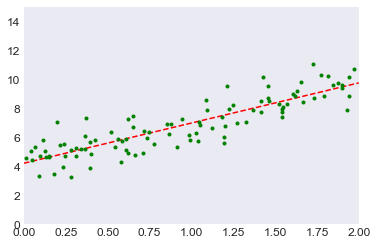

In [5]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # 모든 샘플에 x0 = 1을 추가합니다.
y_predict = X_new_b.dot(theta_best)

print(y_predict)

plt.plot(X_new, y_predict, "r--")
plt.plot(X, y, "g.")
plt.axis([0, 2, 0, 15])
plt.show()

### solution by sklearn (pseudo-inverse)
* 해석적 방법을 이용하려면 X'X의 역행렬을 직접 구해야한다.
* sklearn에서는 SVD를 이용해 X의 유사역행렬을 구한다.

유사역행렬을 계산하는 방식이 훨씬 효율적이며,  
X'X의 역행렬이 존재하지 않는 경우(특성의 수가 관측 수보다 많은경우) 등도 처리할 수 있다.

In [6]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)

print(lin_reg.intercept_, lin_reg.coef_)
print(lin_reg.predict(X_new))

[4.21509616] [[2.77011339]]
[[4.21509616]
 [9.75532293]]


## Computational Complexity
* 정규방정식을 이용할경우 계산복잡도는 O(p^2.4) ~ O(p^3) 사이 
* 유사역행렬을 이용하여 구하는 경우 약 O(p^2) 이다.
<br/>

정규방정식, SVD방법 모두 특성의 수(p)에 대해 quadratic만큼의 복잡도를 갖는다.  
반면 관측의 수 n에 대해서는 linear한 복잡도를 갖는다!!

# 2. Gradient Descent

In [7]:
# batch GD (full dataset per one update)
eta = 0.1
n_iterations = 1000
m = 100

theta = np.random.randn(2, 1)

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

print(theta)

[[4.21509616]
 [2.77011339]]


### Stochastic Gradient Descent
* 매 반복마다 훈련셋 중 하나의 샘플만 메모리에 있으면 되므로 매우 큰 훈련셋도 훈련시킬 수 있음. (외부메모리 학습으로 구현가능)
* 확률적이여서 각 업데이트가 매우 불안정.
* 지역최솟값을 탈출하기는 쉬우나 전역최솟값에 수렴하기 어려움
* 이 문제를 해결하기 위해 일반적으로 learning rate schedule 함수를 사용함.

In [8]:
# stochastic GD (one data point per one update)
eta = 0.1
n_epochs = 50
t0, t1 = 5, 50
m = 100

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2, 1)

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
print(theta)

[[4.18475289]
 [2.73036719]]


In [9]:
# in sklearn
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter = 1000, tol = 1e-3, penalty = None, eta0 = 0.1)
sgd_reg.fit(X, y.ravel())

print(sgd_reg.intercept_, sgd_reg.coef_)

[4.22609703] [2.79227913]


### Mini-Batch Gradient Descent
* 반복당 몇개의 랜덤샘플만을 이용하여 업데이트 진행 
* SGD보다는 수렴이 안정적
* GPU 계산효율을 최대한으로 뽑을 수 있음
* SGD와 마찬가지로 learning rate schedule

In [10]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # 랜덤 초기화

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_iterations):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)
        
print(theta)

[[4.25214635]
 [2.7896408 ]]


# 3. Polynomial Regression

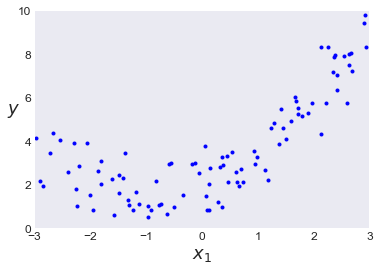

In [11]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

In [12]:
# 훈련셋의 특성을 제곱한 새로운 특성생성
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree = 2, include_bias = False)
X_poly = poly_features.fit_transform(X)
print(X[:3])
print(X_poly[:3]) # 원래 특성과 제곱특성을 포함

[[ 2.38942838]
 [ 1.66081999]
 [-2.54112027]]
[[ 2.38942838  5.709368  ]
 [ 1.66081999  2.75832305]
 [-2.54112027  6.45729221]]


[1.9735233] [[0.95038538 0.52577032]]


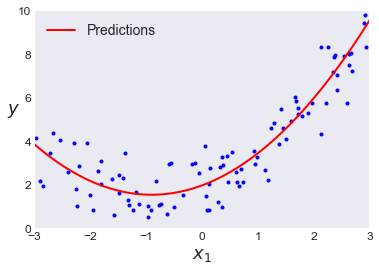

In [13]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
print(lin_reg.intercept_, lin_reg.coef_)

X_new = np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

본 예제에서는 특성이 1 개여서 x, x^2 만 생성됬지만, 특성이 여러개인 경우 교차항까지 추가됨

# 4. Learning Curve
* 얼마나 복잡한 모델을 사용해야할지 어떻게 결정할 수 있나
* overfitting됬는지 underfitting됬는지 어떻게 알 수 있을까

In [14]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   
    plt.xlabel("Training set size", fontsize=14) 
    plt.ylabel("RMSE", fontsize=14)              

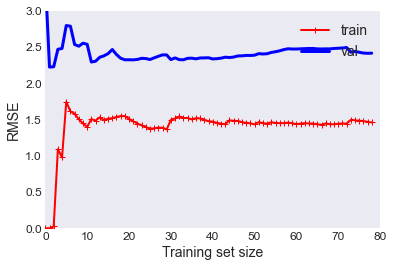

In [15]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])                         
plt.show()                                      

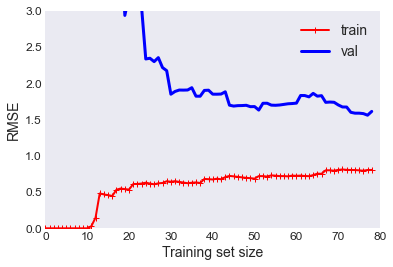

In [16]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ("poly_features", PolynomialFeatures(degree = 10, include_bias = False)),
    ("lin_reg", LinearRegression())
])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])
plt.show()

## Note, Bias Variance trade-off
---
모델의 일반화 오차는 세 가지 다른 종류의 오차의 합으로 표현할 수 있다.
* 편향 : 데이터에 대한 잘못된 모형 가정으로 인한 것 (데이터가 2차인데 선형이라 가정) -> 과소적합 위험
* 분산 : 데이터의 작은 변동에 모델이 과하게 민감. 자유도가 높은 모델이 높은 분산을 가지기 쉬움 -> 과대적합 위험
* 줄일 수 없는 오차 : 데이터 자체에 있는 noise때문에 발생. 이 오차를 줄이려면 잡음/이상치를 제거해야함

# 5. LM with Regularization

### 5.1 Ridge Regression
* 훈련을 진행하는 동안 가중치의 L2 norm 규제항이 비용함수에 추가됨
* <img src = "https://github.com/changdaeoh/HandsOn_ML/blob/main/images/gd_with_l2.jpg?raw=true" width = "50%">

In [19]:
from sklearn.linear_model import Ridge

# ridge by MF
ridge_reg = Ridge(alpha = 1, solver = "cholesky")
ridge_reg.fit(X, y)
p1 = ridge_reg.predict([[1.5]])
print(p1)

# ridge by SGD
sgd_reg = SGDRegressor(penalty = "l2")
sgd_reg.fit(X, y.ravel())
p2 = sgd_reg.predict([[1.5]])
print(p2)

[[5.13357033]]
[5.12249103]


### 5.2 Lasso Regression
* 훈련을 진행하는 동안 가중치의 L1 norm 규제항이 비용함수에 추가됨
* automatic하게 특성을 선택하고 희소모델을 만듬
* 각 가중치가 0일 때 미분이 불가능(V자형)하기때문에 subgradient vector를 사용한다.
<img src = "https://github.com/changdaeoh/HandsOn_ML/blob/main/images/ch4_subgradient_of_lasso.png?raw=true" width = "75%">
* ridge vs lasso 이미지첨부
<img src = "https://github.com/changdaeoh/HandsOn_ML/blob/main/images/ch4_ridge_and_lasso.png?raw=true" width = "75%">

In [21]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha = 0.1) # SGDRegressor(penalty = "l1") 과 동일
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([5.09481859])

### 5.3 Elastic Net
* l1 norm, l2 norm의 가중합을 penalty term으로써 추가 (합의 비율은 하이퍼파리미터)
* 일반적으로 규제가 약간이라도 있는게 좋음. ridge 무난
* 유용한 특성이 몇 개뿐이라고 의심된다면 라쏘와 엘라스틱넷이 나음
* 특성 수가 훈련 샘플 수보다 많거나 특성들간에 강한 상관관계가 있을 때, 라쏘보다 enet이 나음

In [22]:
from sklearn.linear_model import ElasticNet

enet = ElasticNet(alpha = 0.1, l1_ratio = 0.5) 
enet.fit(X, y)
enet.predict([[1.5]])

array([5.09373477])

### 5.4 early stopping
> 경사 하강법과 같은 반복적 학습 알고리즘을 규제하는 방법으로 <br/>
validation loss가 적정수준 이하로 떨어지면 훈련 중지시키는 방법<br/>
(혹은 일정횟수 이상의 반복동안 valid loss가 개선되지 않을 때 stop)

<img src = "https://github.com/changdaeoh/HandsOn_ML/blob/main/images/4_20.png?raw=true" width = "60%">

In [24]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

In [35]:
from sklearn.preprocessing import StandardScaler
from copy import deepcopy

# data prepare
poly_scaler = Pipeline([
    ("poly_features", PolynomialFeatures(degree = 90, include_bias = False)),
    ("std_scaler", StandardScaler())
])
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

# warm_start를 True로 설정하여 fit이 여러번 호출될 때, 
# 이전의 가중치를 이어받아 훈련시작
sgd_reg = SGDRegressor(max_iter = 1, tol = -np.infty, warm_start = True,
                       penalty = None, learning_rate = "constant", eta0 = 0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
patience = 0
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train) 
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)
    else :
        patience += 1
        if patience == 20 : break
            
print(best_epoch, best_model)

239 SGDRegressor(eta0=0.0005, learning_rate='constant', max_iter=1, penalty=None,
             random_state=42, tol=-inf, warm_start=True)


# 6. Logistic Regression
입력 특성값들의 가중합 계산 후 편향을 더하고 sigmoid함수를 거쳐 0과 1사이 출력값 반환  
sigmoid를 거치기 전의 값을 로짓이라고 함. ($logit(p) = log(p/(1-p))$)  
<br/>
* logit은 sigmoid의 역함수

#### 하나의 훈련샘플에 대한 비용함수
$
c(\boldsymbol{\theta}) =
\begin{cases}
  -\log(\hat{p}) & \text{if } y = 1, \\
  -\log(1 - \hat{p}) & \text{if } y = 0.
\end{cases}
$

#### 로지스틱회귀의 비용함수 (모든 개별 샘플의 비용을 평균낸 것)
$
J(\boldsymbol{\theta}) = -\dfrac{1}{m} \sum\limits_{i=1}^{m}{\left[ y^{(i)} log\left(\hat{p}^{(i)}\right) + (1 - y^{(i)}) log\left(1 - \hat{p}^{(i)}\right)\right]}
$

이는 convex함수여서 경사하강법등으로 global minimum에 도달하는 것이 보장됨

In [38]:
from sklearn import datasets
iris  = datasets.load_iris()
print(list(iris.keys()))
X = iris["data"][:, 3:]
y = (iris["target"] == 2).astype(np.int)

from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X, y)
print(log_reg.predict([[1.7], [1.5]]))

['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename']
[1 0 1]


## softmax regression
#### 소프트맥스 함수

$
\hat{p}_k = \sigma\left(\mathbf{s}(\mathbf{x})\right)_k = \dfrac{\exp\left(s_k(\mathbf{x})\right)}{\sum\limits_{j=1}^{K}{\exp\left(s_j(\mathbf{x})\right)}}
$
* K : 클래스 수
* s(x) : 샘플 x에 대한 각 클래스의 점수를 담은 벡터
* note, 각 클래스 k마다 가중치벡터 $\theta_{k}$를 가짐.
* softmax regression 모델의 전체 가중치는 $\theta_{k}$들을 모은 행렬

#### 크로스 엔트로피 비용 함수

$
J(\boldsymbol{\Theta}) = - \dfrac{1}{m}\sum\limits_{i=1}^{m}\sum\limits_{k=1}^{K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)}
$

In [39]:
X = iris["data"][:, (2, 3)]  
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10)
softmax_reg.fit(X, y)
print(softmax_reg.predict([[5,2]]))
print(softmax_reg.predict_proba([[5,2]]))

[2]
[[6.38014896e-07 5.74929995e-02 9.42506362e-01]]
